# Car Classification Model Training

This notebook trains a Hybrid ResNet-ViT model for Indonesian car classification using the collected dataset. The model combines ResNet-50 as a feature extractor with a Vision Transformer for classification.

## Dataset Structure
- **Classes**: 8 Indonesian car types (hatchback, mpv, offroad, pickup, sedan, suv, truck, van)
- **Architecture**: Hybrid ResNet-ViT combining CNN and Transformer
- **Training Strategy**: Transfer learning with data augmentation
- **Class Imbalance**: Handled using weighted loss function for better minority class performance

## Training Process
1. Dataset exploration and class imbalance analysis
2. Model training with weighted loss and comprehensive tracking
3. Performance analysis with detailed charts and metrics
4. Model evaluation with per-class analysis and confusion matrix
5. Training insights and recommendations for optimization

In [1]:
!rm -rf /kaggle/working
!git clone https://github.com/luthfiarifin/Hybrid-RViT-Car-Retrieval.git code
!mv code/* .
!ls

rm: cannot remove '/kaggle/working': Device or resource busy
Cloning into 'code'...
remote: Enumerating objects: 15214, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 15214 (delta 21), reused 35 (delta 16), pack-reused 15172 (from 1)
Receiving objects: 100% (15214/15214), 257.93 MiB | 47.74 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (16756/16756), done.
1_run_scraper_into_dataset.ipynb	code		 models
2_train_the_classification_model.ipynb	data_processing


In [2]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
)
import time
import os
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

# Set style for plots
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(
        f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB"
    )

Libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB
CUDA memory: 15.9 GB


=== Dataset Exploration ===

Training set:
  hatchback: 1921 images
  mpv: 2609 images
  offroad: 892 images
  pickup: 1039 images
  sedan: 2429 images
  suv: 3184 images
  truck: 414 images
  van: 895 images
  Total training images: 13383

Validation set:
  hatchback: 240 images
  mpv: 326 images
  offroad: 111 images
  pickup: 130 images
  sedan: 304 images
  suv: 398 images
  truck: 52 images
  van: 112 images
  Total validation images: 1673


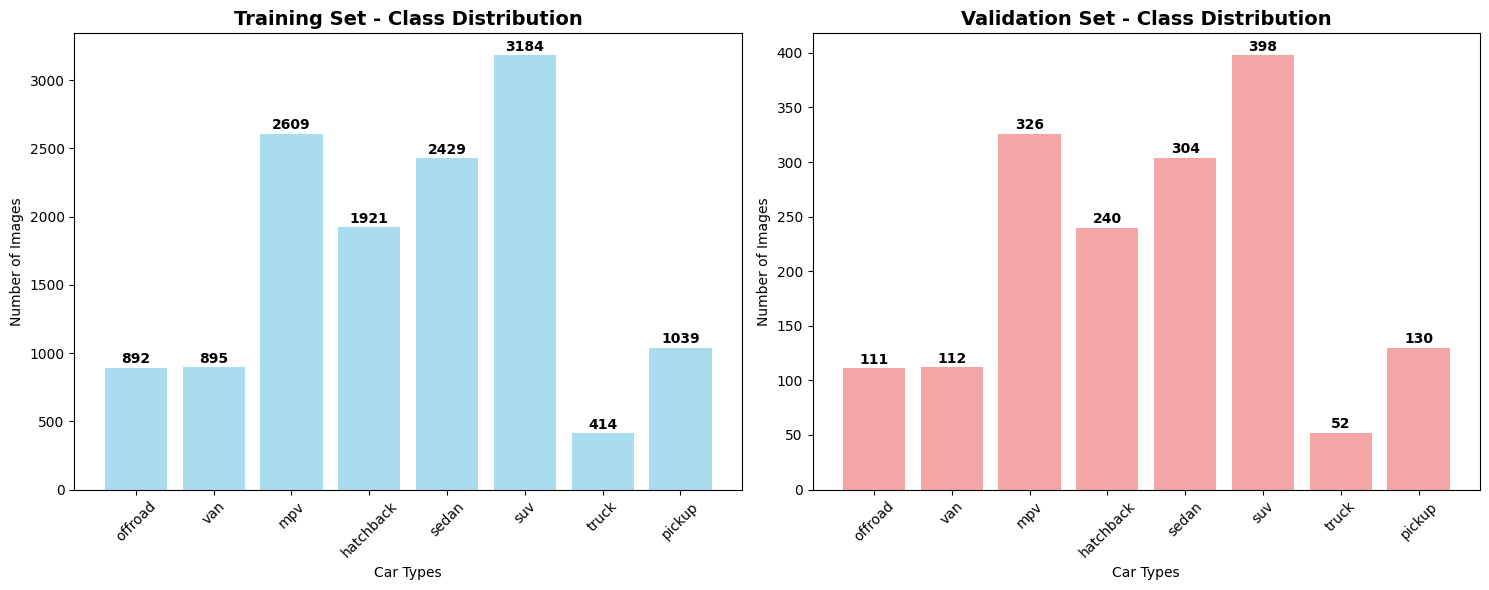


=== Dataset Summary ===
    Class  Training  Validation  Total  Train_Ratio
  offroad       892         111   1003        0.889
      van       895         112   1007        0.889
      mpv      2609         326   2935        0.889
hatchback      1921         240   2161        0.889
    sedan      2429         304   2733        0.889
      suv      3184         398   3582        0.889
    truck       414          52    466        0.888
   pickup      1039         130   1169        0.889


In [3]:
# Dataset exploration
def explore_dataset(data_dir):
    """Explore the dataset structure and class distribution"""
    if not os.path.exists(data_dir):
        print(f"Dataset directory {data_dir} not found!")
        return None

    # Get class names and counts
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            count = len(
                [
                    f
                    for f in os.listdir(class_path)
                    if f.lower().endswith((".jpg", ".jpeg", ".png"))
                ]
            )
            class_counts[class_name] = count

    return class_counts


# Explore training and validation datasets
train_data_dir = "data_processing/data/dataset/train"
val_data_dir = "data_processing/data/dataset/val"

print("=== Dataset Exploration ===")
train_counts = explore_dataset(train_data_dir)
val_counts = explore_dataset(val_data_dir)

if train_counts:
    print(f"\nTraining set:")
    for class_name, count in sorted(train_counts.items()):
        print(f"  {class_name}: {count} images")
    print(f"  Total training images: {sum(train_counts.values())}")

if val_counts:
    print(f"\nValidation set:")
    for class_name, count in sorted(val_counts.items()):
        print(f"  {class_name}: {count} images")
    print(f"  Total validation images: {sum(val_counts.values())}")

# Visualize class distribution
if train_counts and val_counts:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Training set distribution
    classes = list(train_counts.keys())
    train_values = list(train_counts.values())
    ax1.bar(classes, train_values, color="skyblue", alpha=0.7)
    ax1.set_title("Training Set - Class Distribution", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Car Types")
    ax1.set_ylabel("Number of Images")
    ax1.tick_params(axis="x", rotation=45)

    # Add value labels on bars
    for i, v in enumerate(train_values):
        ax1.text(
            i, v + max(train_values) * 0.01, str(v), ha="center", fontweight="bold"
        )

    # Validation set distribution
    val_values = [val_counts.get(cls, 0) for cls in classes]
    ax2.bar(classes, val_values, color="lightcoral", alpha=0.7)
    ax2.set_title("Validation Set - Class Distribution", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Car Types")
    ax2.set_ylabel("Number of Images")
    ax2.tick_params(axis="x", rotation=45)

    # Add value labels on bars
    for i, v in enumerate(val_values):
        ax2.text(i, v + max(val_values) * 0.01, str(v), ha="center", fontweight="bold")

    plt.tight_layout()
    plt.show()

    # Create a summary dataframe
    df_summary = pd.DataFrame(
        {
            "Class": classes,
            "Training": train_values,
            "Validation": val_values,
            "Total": [train_values[i] + val_values[i] for i in range(len(classes))],
            "Train_Ratio": [
                train_values[i] / (train_values[i] + val_values[i])
                for i in range(len(classes))
            ],
        }
    )
    df_summary["Train_Ratio"] = df_summary["Train_Ratio"].round(3)
    print("\n=== Dataset Summary ===")
    print(df_summary.to_string(index=False))

In [4]:
# Training configuration with class imbalance handling

from models.classification.train_classification import CarClassifierTrainer

CONFIG = {
    "train_dir": train_data_dir,
    "val_dir": val_data_dir,
    "num_classes": 8,
    "embed_dim": 768,
    "num_heads": 12,
    "num_layers": 6,
    "dropout": 0.1,
    "learning_rate": 1e-4,
    "batch_size": 64,
    "num_epochs": 25,
    "result_path": f'models/results/carvit_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth',
    "use_weighted_loss": True,
    "use_class_balancing": False,
    "num_workers": 8,
    "early_stopping_patience": 7,
    "early_stopping_delta": 0.001,
    "early_stopping_verbose": True,
}

print("=== Training Configuration ===")
for key, value in CONFIG.items():
    print(f"{key}: {value}")

# Initialize the trainer with class imbalance handling and early stopping
print("\n=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===")
trainer = CarClassifierTrainer(
    train_dir=CONFIG["train_dir"],
    val_dir=CONFIG["val_dir"],
    num_classes=CONFIG["num_classes"],
    embed_dim=CONFIG["embed_dim"],
    num_heads=CONFIG["num_heads"],
    num_layers=CONFIG["num_layers"],
    dropout=CONFIG["dropout"],
    learning_rate=CONFIG["learning_rate"],
    batch_size=CONFIG["batch_size"],
    num_epochs=CONFIG["num_epochs"],
    result_path=CONFIG["result_path"],
    use_weighted_loss=CONFIG["use_weighted_loss"],
    use_class_balancing=CONFIG["use_class_balancing"],
    num_workers=CONFIG["num_workers"],
    early_stopping_patience=CONFIG["early_stopping_patience"],
    early_stopping_delta=CONFIG["early_stopping_delta"],
    early_stopping_verbose=CONFIG["early_stopping_verbose"],
)

print("Trainer initialized successfully!")
print(f"Training samples: {len(trainer.train_dataset)}")
print(f"Validation samples: {len(trainer.val_dataset)}")
print(f"Number of batches per epoch: {len(trainer.train_loader)}")
print(f"Class names: {trainer.train_dataset.classes}")

=== Training Configuration ===
train_dir: data_processing/data/dataset/train
val_dir: data_processing/data/dataset/val
num_classes: 8
embed_dim: 768
num_heads: 12
num_layers: 6
dropout: 0.1
learning_rate: 0.0001
batch_size: 64
num_epochs: 25
result_path: models/results/carvit_model_20250622_092251.pth
use_weighted_loss: True
use_class_balancing: False
num_workers: 8
early_stopping_patience: 7
early_stopping_delta: 0.001
early_stopping_verbose: True

=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===
Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]


Using weighted CrossEntropyLoss with weights: tensor([0.8708, 0.6412, 1.8754, 1.6101, 0.6887, 0.5254, 4.0408, 1.8691],
       device='cuda:0')

📊 Class Distribution Analysis:
Class        Count    Percentage Imbalance Ratio
--------------------------------------------------
hatchback    1921     14.4      % 1.66           x
mpv          2609     19.5      % 1.22           x
offroad      892      6.7       % 3.57           x
pickup       1039     7.8       % 3.06           x
sedan        2429     18.1      % 1.31           x
suv          3184     23.8      % 1.00           x
truck        414      3.1       % 7.69           x
van          895      6.7       % 3.56           x

📈 Imbalance Factor: 7.69x (Most frequent / Least frequent)
⚠️  High imbalance detected! Consider using weighted loss or resampling.
Trainer initialized successfully!
Training samples: 13383
Validation samples: 1673
Number of batches per epoch: 210
Class names: ['hatchback', 'mpv', 'offroad', 'pickup', 'sedan', 'suv

In [5]:
# Start training with detailed tracking
print("🚀 Starting model training...")
start_time = time.time()

# Execute training
training_results = trainer.train()

total_time = time.time() - start_time
print(f"\n🎉 Training completed in {total_time/60:.2f} minutes!")
print(f"📊 Training Results Summary:")
print(f"- Best Validation Accuracy: {training_results['best_accuracy']:.2f}%")
print(f"- Final Training Loss: {training_results['train_losses'][-1]:.4f}")
print(f"- Final Validation Loss: {training_results['val_losses'][-1]:.4f}")
print(f"- Average Time per Epoch: {np.mean(training_results['epoch_times']):.2f}s")

🚀 Starting model training...
Starting training with detailed tracking and early stopping...
Early Stopping - Patience: 7, Delta: 0.001
Model parameters: 143,116,360
Trainable parameters: 143,116,360

Epoch 1/25


100%|██████████| 210/210 [02:00<00:00,  1.74it/s, loss=0.866]


Validation accuracy: 59.18%
Validation loss: 1.1103
Time: 126.96s | LR: 1.00e-04
🎉 New best accuracy: 59.18%
Validation loss decreased (inf --> 1.110284).  Saving model ...

Epoch 2/25


100%|██████████| 210/210 [02:02<00:00,  1.71it/s, loss=0.448]


Validation accuracy: 72.27%
Validation loss: 0.7848
Time: 128.64s | LR: 1.00e-04
🎉 New best accuracy: 72.27%
Validation loss decreased (1.110284 --> 0.784755).  Saving model ...

Epoch 3/25


100%|██████████| 210/210 [02:02<00:00,  1.72it/s, loss=0.337]


Validation accuracy: 76.21%
Validation loss: 0.6453
Time: 128.93s | LR: 1.00e-04
🎉 New best accuracy: 76.21%
Validation loss decreased (0.784755 --> 0.645311).  Saving model ...

Epoch 4/25


100%|██████████| 210/210 [02:02<00:00,  1.72it/s, loss=0.996]


Validation accuracy: 80.63%
Validation loss: 0.5849
Time: 129.00s | LR: 1.00e-04
🎉 New best accuracy: 80.63%
Validation loss decreased (0.645311 --> 0.584933).  Saving model ...

Epoch 5/25


100%|██████████| 210/210 [02:02<00:00,  1.71it/s, loss=0.601]


Validation accuracy: 83.68%
Validation loss: 0.4689
Time: 128.77s | LR: 1.00e-04
🎉 New best accuracy: 83.68%
Validation loss decreased (0.584933 --> 0.468892).  Saving model ...

Epoch 6/25


100%|██████████| 210/210 [02:02<00:00,  1.72it/s, loss=0.85] 


Validation accuracy: 82.79%
Validation loss: 0.5328
Time: 128.74s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 7/25


100%|██████████| 210/210 [02:02<00:00,  1.71it/s, loss=0.0946]


Validation accuracy: 81.41%
Validation loss: 0.5736
Time: 129.10s | LR: 1.00e-04
EarlyStopping counter: 2 out of 7

Epoch 8/25


100%|██████████| 210/210 [02:03<00:00,  1.70it/s, loss=0.206] 


Validation accuracy: 85.83%
Validation loss: 0.4326
Time: 130.23s | LR: 1.00e-04
🎉 New best accuracy: 85.83%
Validation loss decreased (0.468892 --> 0.432551).  Saving model ...

Epoch 9/25


100%|██████████| 210/210 [02:03<00:00,  1.71it/s, loss=0.28]  


Validation accuracy: 84.58%
Validation loss: 0.4919
Time: 129.58s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 10/25


100%|██████████| 210/210 [02:02<00:00,  1.71it/s, loss=0.0655]


Validation accuracy: 85.77%
Validation loss: 0.5104
Time: 129.48s | LR: 1.00e-04
EarlyStopping counter: 2 out of 7

Epoch 11/25


100%|██████████| 210/210 [02:02<00:00,  1.71it/s, loss=0.0743]


Validation accuracy: 84.58%
Validation loss: 0.5520
Time: 129.43s | LR: 1.00e-04
EarlyStopping counter: 3 out of 7

Epoch 12/25


100%|██████████| 210/210 [02:02<00:00,  1.72it/s, loss=1.27]  


Validation accuracy: 86.97%
Validation loss: 0.4790
Time: 128.80s | LR: 1.00e-04
🎉 New best accuracy: 86.97%
EarlyStopping counter: 4 out of 7

Epoch 13/25


100%|██████████| 210/210 [02:02<00:00,  1.71it/s, loss=0.378] 


Validation accuracy: 86.67%
Validation loss: 0.5118
Time: 129.36s | LR: 1.00e-04
EarlyStopping counter: 5 out of 7

Epoch 14/25


100%|██████████| 210/210 [02:01<00:00,  1.73it/s, loss=0.02]  


Validation accuracy: 86.67%
Validation loss: 0.4876
Time: 128.42s | LR: 1.00e-04
EarlyStopping counter: 6 out of 7

Epoch 15/25


100%|██████████| 210/210 [02:02<00:00,  1.72it/s, loss=0.102] 


Validation accuracy: 88.11%
Validation loss: 0.4303
Time: 128.80s | LR: 1.00e-04
🎉 New best accuracy: 88.11%
Validation loss decreased (0.432551 --> 0.430343).  Saving model ...

Epoch 16/25


100%|██████████| 210/210 [02:02<00:00,  1.71it/s, loss=0.496] 


Validation accuracy: 88.40%
Validation loss: 0.4853
Time: 128.98s | LR: 1.00e-04
🎉 New best accuracy: 88.40%
EarlyStopping counter: 1 out of 7

Epoch 17/25


100%|██████████| 210/210 [02:02<00:00,  1.72it/s, loss=0.48]  


Validation accuracy: 85.36%
Validation loss: 0.5979
Time: 128.70s | LR: 1.00e-04
EarlyStopping counter: 2 out of 7

Epoch 18/25


100%|██████████| 210/210 [02:02<00:00,  1.72it/s, loss=0.0321]


Validation accuracy: 87.93%
Validation loss: 0.4303
Time: 128.62s | LR: 1.00e-04
EarlyStopping counter: 3 out of 7

Epoch 19/25


100%|██████████| 210/210 [02:02<00:00,  1.72it/s, loss=0.00572]


Validation accuracy: 86.55%
Validation loss: 0.5616
Time: 128.40s | LR: 1.00e-04
EarlyStopping counter: 4 out of 7

Epoch 20/25


100%|██████████| 210/210 [02:02<00:00,  1.72it/s, loss=0.316] 


Validation accuracy: 88.94%
Validation loss: 0.4302
Time: 128.31s | LR: 1.00e-04
🎉 New best accuracy: 88.94%
EarlyStopping counter: 5 out of 7

Epoch 21/25


100%|██████████| 210/210 [02:02<00:00,  1.72it/s, loss=0.0601]


Validation accuracy: 87.75%
Validation loss: 0.4928
Time: 128.38s | LR: 1.00e-04
EarlyStopping counter: 6 out of 7

Epoch 22/25


100%|██████████| 210/210 [02:01<00:00,  1.73it/s, loss=0.678] 


Validation accuracy: 87.15%
Validation loss: 0.5412
Time: 128.01s | LR: 1.00e-04
EarlyStopping counter: 7 out of 7

🛑 Early stopping triggered at epoch 22
Best validation loss: 0.430343

Training completed!
Training stopped early at epoch 22 due to no improvement in validation loss
Best validation accuracy: 88.94%
Loading best model with validation loss: 0.430343
Best accuracy model saved to models/results/carvit_model_20250622_092251_best_acc.pth

🎉 Training completed in 47.42 minutes!
📊 Training Results Summary:
- Best Validation Accuracy: 88.94%
- Final Training Loss: 0.1495
- Final Validation Loss: 0.5412
- Average Time per Epoch: 128.80s


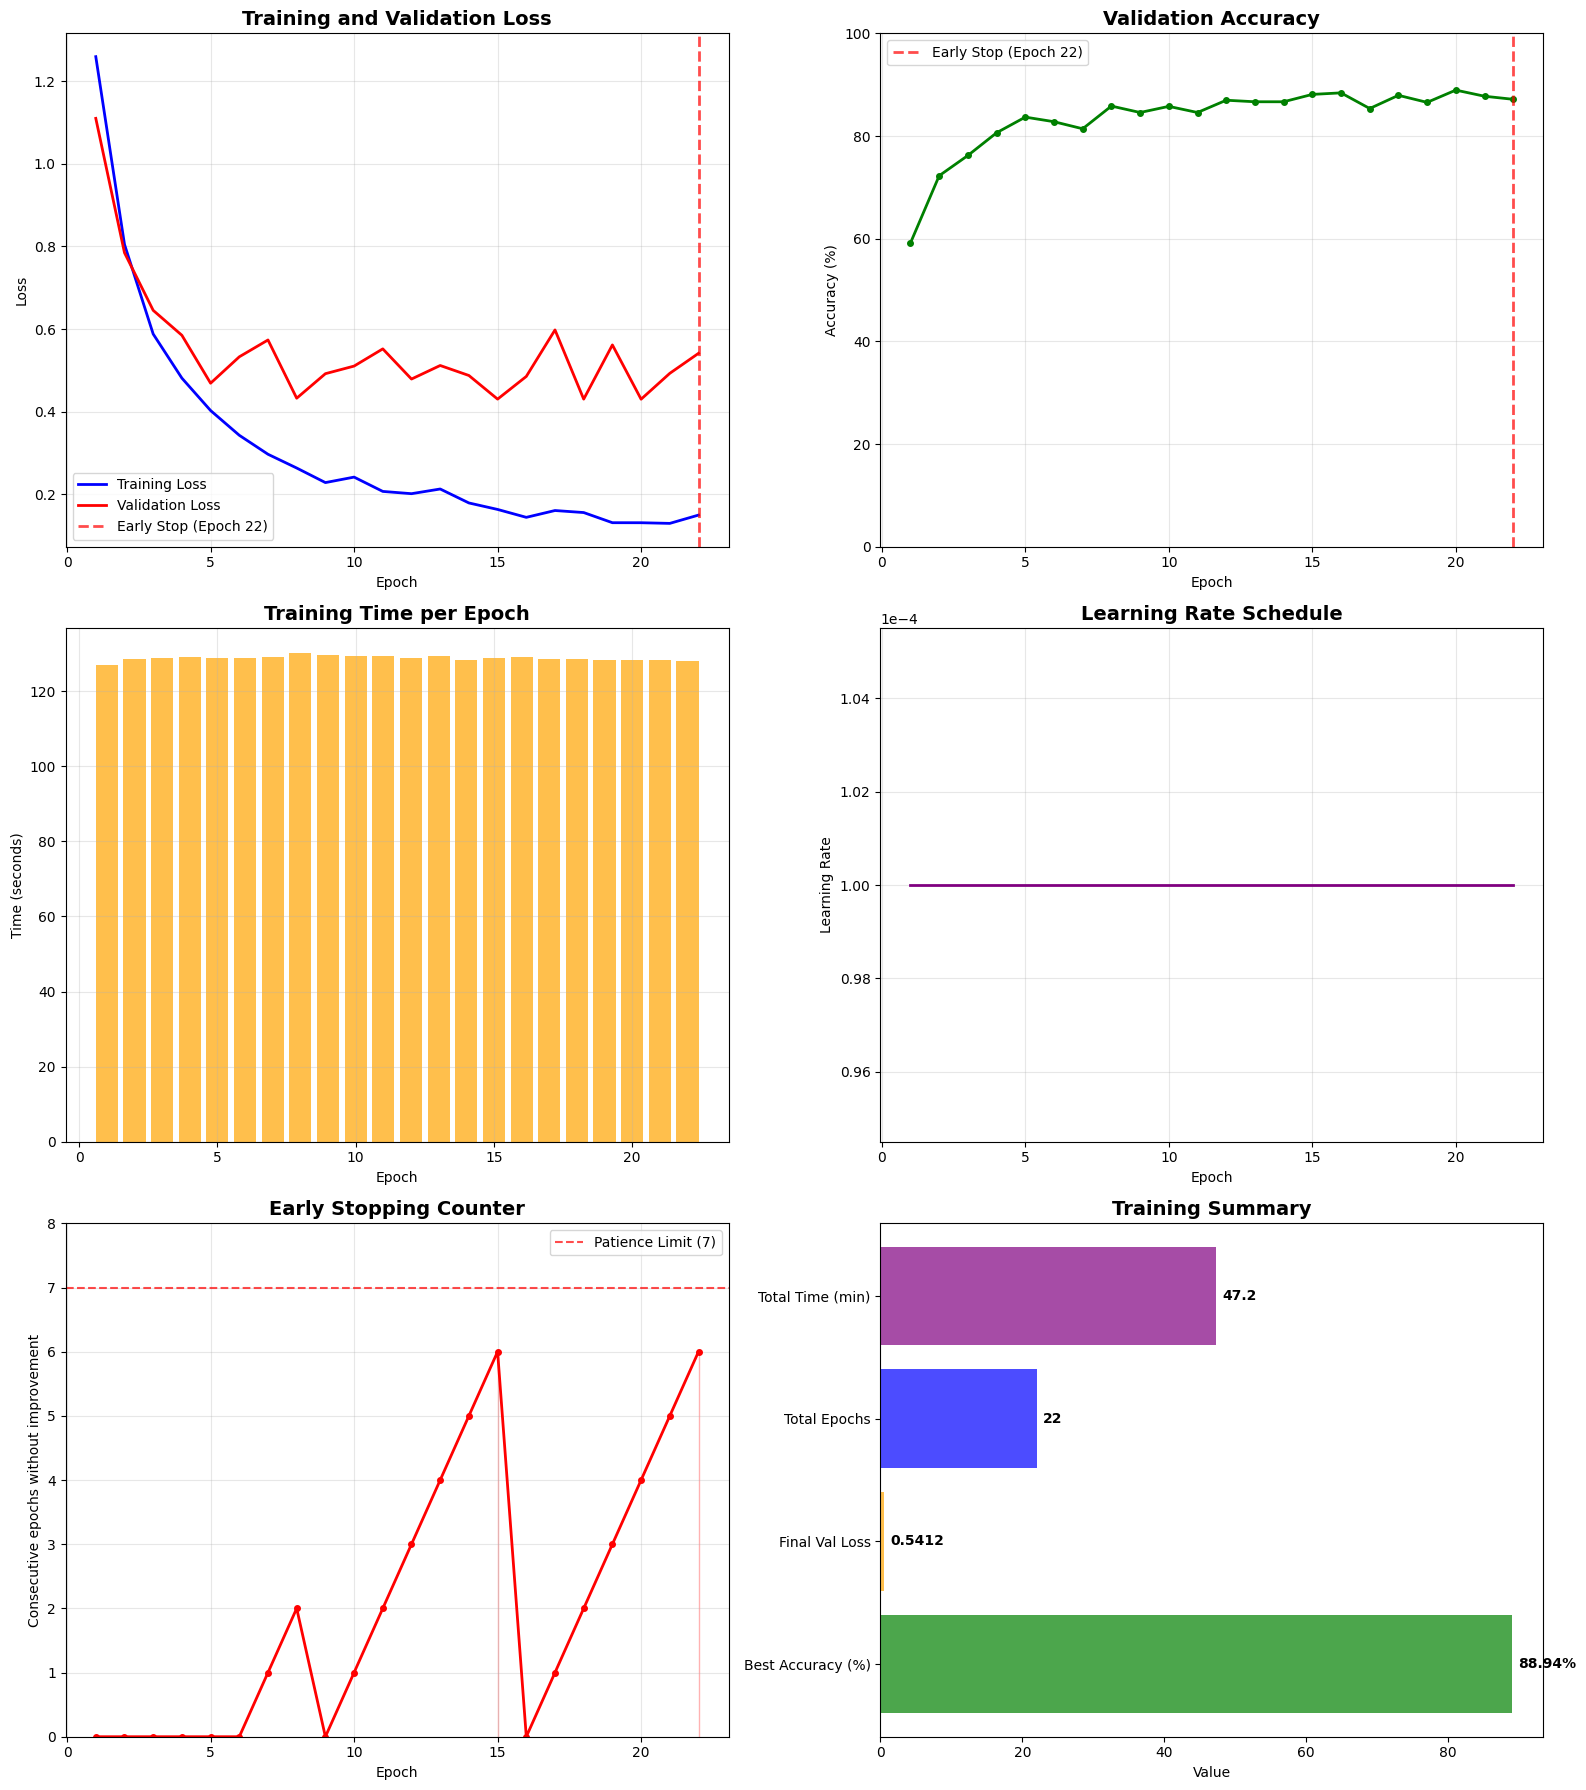

🛑 Early Stopping Analysis:
✅ Early stopping was triggered!
📍 Stopped at epoch: 22/25
⏰ Training time saved: ~6.4 minutes
🎯 Best validation loss: 0.430343
📈 Final validation accuracy: 87.15%
🏆 Best validation accuracy: 88.94% (Epoch 20)
ℹ️  Best accuracy was achieved 2 epochs before early stopping
📉 Total validation loss improvement: 0.679942

📈 Detailed Training Statistics:
- Loss Reduction: 1.2597 → 0.1495 (88.1% improvement)
- Best Accuracy: 88.94% (Epoch 20)
- Total Training Time: 47.23 minutes
- Average Time per Epoch: 128.80s
- Fastest Epoch: 126.96s
- Slowest Epoch: 130.23s
- Max Early Stop Counter: 6
- Average Early Stop Counter: 2.05
- Times Close to Early Stop (>5): 2

📋 Training Metrics Table (Last 5 Epochs):
 Epoch  Train_Loss  Val_Loss  Val_Accuracy  Epoch_Time  Learning_Rate  ES_Counter
    18      0.1556    0.4303         87.93      128.62         0.0001           2
    19      0.1311    0.5616         86.55      128.40         0.0001           3
    20      0.1310    0.4

In [7]:
# Comprehensive Training Analysis and Visualization

# 1. Training Progress Visualization
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 18))

epochs = range(1, len(training_results["train_losses"]) + 1)

# Loss curves
ax1.plot(
    epochs, training_results["train_losses"], "b-", label="Training Loss", linewidth=2
)
ax1.plot(
    epochs, training_results["val_losses"], "r-", label="Validation Loss", linewidth=2
)
ax1.set_title("Training and Validation Loss", fontsize=14, fontweight="bold")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add early stopping marker if triggered
if training_results.get("early_stopping_triggered", False):
    stopped_epoch = training_results["stopped_epoch"]
    ax1.axvline(x=stopped_epoch, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Early Stop (Epoch {stopped_epoch})')
    ax1.legend()

# Accuracy curve
ax2.plot(
    epochs,
    training_results["val_accuracies"],
    "g-",
    linewidth=2,
    marker="o",
    markersize=4,
)
ax2.set_title("Validation Accuracy", fontsize=14, fontweight="bold")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

# Add early stopping marker for accuracy
if training_results.get("early_stopping_triggered", False):
    ax2.axvline(x=stopped_epoch, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Early Stop (Epoch {stopped_epoch})')
    ax2.legend()

# Training time per epoch
ax3.bar(epochs, training_results["epoch_times"], color="orange", alpha=0.7)
ax3.set_title("Training Time per Epoch", fontsize=14, fontweight="bold")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Time (seconds)")
ax3.grid(True, alpha=0.3)

# Learning rate schedule
ax4.plot(epochs, training_results["learning_rates"], "purple", linewidth=2)
ax4.set_title("Learning Rate Schedule", fontsize=14, fontweight="bold")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Learning Rate")
ax4.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
ax4.grid(True, alpha=0.3)

# Early Stopping Counter History
if "early_stopping_counter_history" in training_results:
    counter_history = training_results["early_stopping_counter_history"]
    patience = training_results.get("early_stopping_patience", 7)
    
    ax5.plot(epochs, counter_history, "red", linewidth=2, marker="o", markersize=4)
    ax5.axhline(y=patience, color='red', linestyle='--', alpha=0.7, label=f'Patience Limit ({patience})')
    ax5.set_title("Early Stopping Counter", fontsize=14, fontweight="bold")
    ax5.set_xlabel("Epoch")
    ax5.set_ylabel("Consecutive epochs without improvement")
    ax5.set_ylim([0, max(max(counter_history), patience) + 1])
    ax5.grid(True, alpha=0.3)
    ax5.legend()
    
    # Fill danger zone
    ax5.fill_between(epochs, 0, counter_history, where=np.array(counter_history) >= patience-1, 
                     alpha=0.3, color='red', label='Danger Zone')

# Model Performance Summary
total_epochs = len(epochs)
actual_epochs = training_results.get("stopped_epoch", total_epochs)
best_epoch = training_results["val_accuracies"].index(max(training_results["val_accuracies"])) + 1

def to_py(val):
    if hasattr(val, 'item'):
        return val.cpu().item() if val.is_cuda else val.item()
    return float(val)

performance_data = [
    to_py(training_results["best_accuracy"]),
    to_py(training_results["val_losses"][-1]),
    int(actual_epochs),
    float(sum(training_results["epoch_times"])/60)
]
performance_labels = ['Best Accuracy (%)', 'Final Val Loss', 'Total Epochs', 'Total Time (min)']

ax6.barh(performance_labels, performance_data, color=['green', 'orange', 'blue', 'purple'], alpha=0.7)
ax6.set_title("Training Summary", fontsize=14, fontweight="bold")
ax6.set_xlabel("Value")

# Add value labels on bars
for i, v in enumerate(performance_data):
    if i == 0:  # Accuracy
        ax6.text(v + max(performance_data) * 0.01, i, f'{v:.2f}%', va='center', fontweight='bold')
    elif i == 1:  # Loss
        ax6.text(v + max(performance_data) * 0.01, i, f'{v:.4f}', va='center', fontweight='bold')
    elif i == 2:  # Epochs
        ax6.text(v + max(performance_data) * 0.01, i, f'{int(v)}', va='center', fontweight='bold')
    else:  # Time
        ax6.text(v + max(performance_data) * 0.01, i, f'{v:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Early Stopping Analysis
print("🛑 Early Stopping Analysis:")
print("=" * 50)
if training_results.get("early_stopping_triggered", False):
    stopped_epoch = training_results["stopped_epoch"]
    total_planned = CONFIG["num_epochs"]
    time_saved = sum(training_results["epoch_times"]) / len(training_results["epoch_times"]) * (total_planned - stopped_epoch)
    
    print(f"✅ Early stopping was triggered!")
    print(f"📍 Stopped at epoch: {stopped_epoch}/{total_planned}")
    print(f"⏰ Training time saved: ~{time_saved/60:.1f} minutes")
    print(f"🎯 Best validation loss: {training_results['best_val_loss']:.6f}")
    print(f"📈 Final validation accuracy: {training_results['val_accuracies'][-1]:.2f}%")
    print(f"🏆 Best validation accuracy: {training_results['best_accuracy']:.2f}% (Epoch {best_epoch})")
    
    # Check if best accuracy was achieved before early stopping
    if best_epoch < stopped_epoch:
        print(f"ℹ️  Best accuracy was achieved {stopped_epoch - best_epoch} epochs before early stopping")
    else:
        print(f"ℹ️  Best accuracy was achieved at the final epoch")
        
    # Analyze early stopping effectiveness
    loss_improvement = training_results["val_losses"][0] - training_results["best_val_loss"]
    print(f"📉 Total validation loss improvement: {loss_improvement:.6f}")
    
else:
    print(f"❌ Early stopping was NOT triggered")
    print(f"📍 Training completed all {CONFIG['num_epochs']} epochs")
    print(f"🎯 Final validation loss: {training_results['val_losses'][-1]:.6f}")
    print(f"📈 Final validation accuracy: {training_results['val_accuracies'][-1]:.2f}%")
    print(f"🏆 Best validation accuracy: {training_results['best_accuracy']:.2f}% (Epoch {best_epoch})")
    print(f"💡 Consider: Reducing patience or increasing epochs for better convergence")

# 3. Training Statistics Summary
print("\n📈 Detailed Training Statistics:")
print("=" * 50)
print(
    f"- Loss Reduction: {training_results['train_losses'][0]:.4f} → {training_results['train_losses'][-1]:.4f} ({((training_results['train_losses'][0] - training_results['train_losses'][-1])/training_results['train_losses'][0]*100):.1f}% improvement)"
)
print(
    f"- Best Accuracy: {max(training_results['val_accuracies']):.2f}% (Epoch {training_results['val_accuracies'].index(max(training_results['val_accuracies']))+1})"
)
print(f"- Total Training Time: {sum(training_results['epoch_times'])/60:.2f} minutes")
print(f"- Average Time per Epoch: {np.mean(training_results['epoch_times']):.2f}s")
print(f"- Fastest Epoch: {min(training_results['epoch_times']):.2f}s")
print(f"- Slowest Epoch: {max(training_results['epoch_times']):.2f}s")

# Early stopping counter statistics
if "early_stopping_counter_history" in training_results:
    counter_history = training_results["early_stopping_counter_history"]
    max_counter = max(counter_history)
    avg_counter = np.mean(counter_history)
    print(f"- Max Early Stop Counter: {max_counter}")
    print(f"- Average Early Stop Counter: {avg_counter:.2f}")
    print(f"- Times Close to Early Stop (>{CONFIG['early_stopping_patience']-2}): {sum(1 for x in counter_history if x > CONFIG['early_stopping_patience']-2)}")

# 4. Performance Metrics Table with Early Stopping Info
metrics_df = pd.DataFrame(
    {
        "Epoch": epochs,
        "Train_Loss": training_results["train_losses"],
        "Val_Loss": training_results["val_losses"],
        "Val_Accuracy": training_results["val_accuracies"],
        "Epoch_Time": training_results["epoch_times"],
        "Learning_Rate": training_results["learning_rates"],
        "ES_Counter": training_results.get("early_stopping_counter_history", [0] * len(epochs)),
    }
)

# Round numerical values for better display
metrics_df["Train_Loss"] = metrics_df["Train_Loss"].round(4)
metrics_df["Val_Loss"] = metrics_df["Val_Loss"].round(4)
metrics_df["Val_Accuracy"] = metrics_df["Val_Accuracy"].round(2)
metrics_df["Epoch_Time"] = metrics_df["Epoch_Time"].round(2)

print("\n📋 Training Metrics Table (Last 5 Epochs):")
print(metrics_df.tail().to_string(index=False))

print(f"\n🔍 Early Stopping Configuration:")
print(f"- Patience: {CONFIG['early_stopping_patience']} epochs")
print(f"- Delta: {CONFIG['early_stopping_delta']} (minimum improvement threshold)")
print(f"- Verbose: {CONFIG['early_stopping_verbose']}")
print(f"- Monitoring: Validation Loss (lower is better)")

# Recommendations based on early stopping behavior
print(f"\n💡 Early Stopping Recommendations:")
if training_results.get("early_stopping_triggered", False):
    if training_results["stopped_epoch"] < CONFIG["num_epochs"] * 0.5:
        print("⚠️  Early stopping triggered very early - consider:")
        print("- Reducing learning rate")
        print("- Increasing patience")
        print("- Adding learning rate scheduling")
    else:
        print("✅ Early stopping worked well - good balance of training time and performance")
        print("- Consider similar patience for future experiments")
else:
    final_counter = counter_history[-1] if "early_stopping_counter_history" in training_results else 0
    if final_counter > CONFIG["early_stopping_patience"] * 0.7:
        print("⚠️  Close to early stopping at the end - consider:")
        print("- Increasing total epochs")
        print("- Implementing learning rate decay")
    else:
        print("ℹ️  Model was still improving - consider:")
        print("- Increasing total epochs")
        print("- Reducing patience if training time is a concern")

Class names: ['hatchback', 'mpv', 'offroad', 'pickup', 'sedan', 'suv', 'truck', 'van']


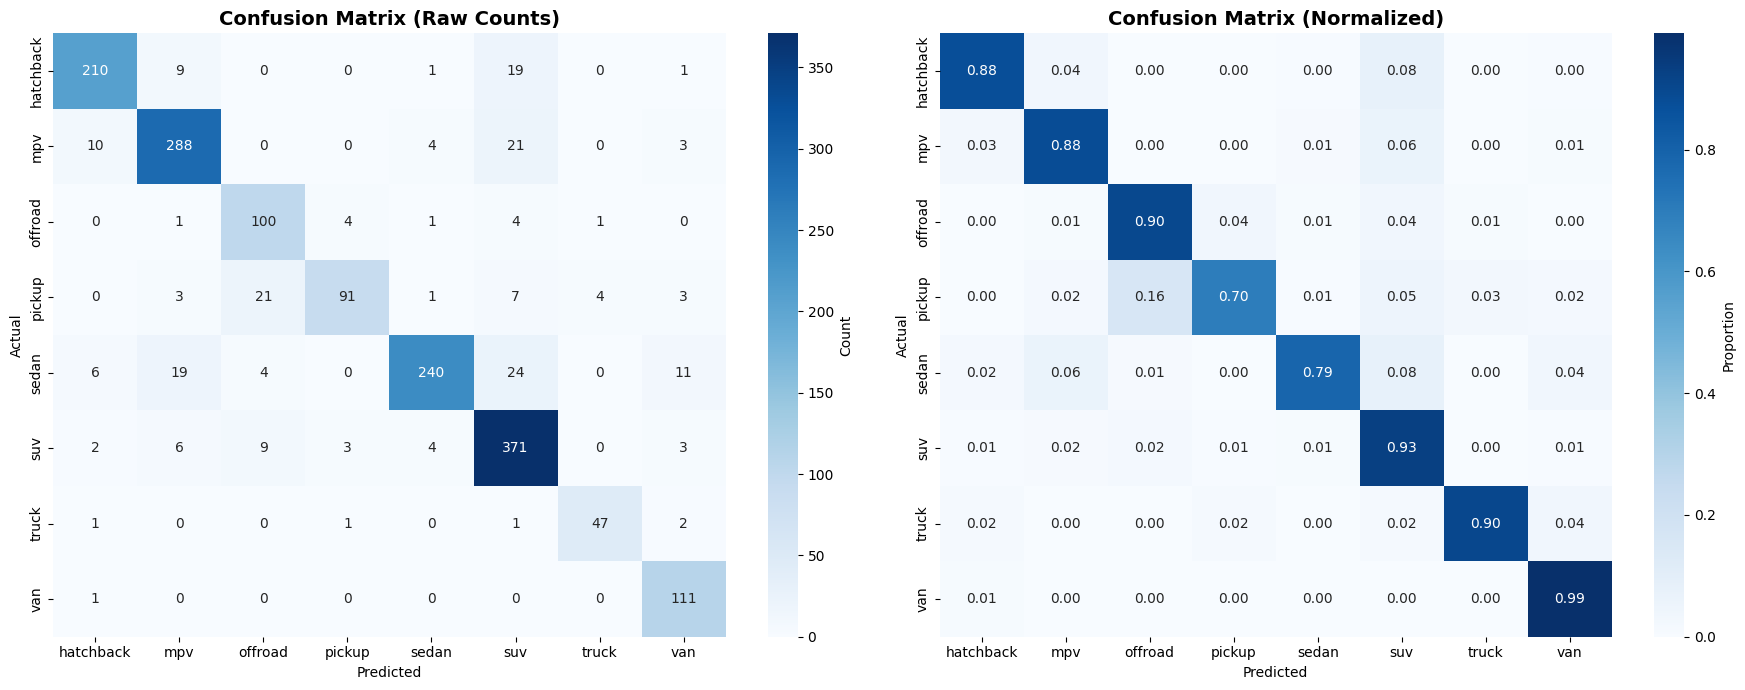


📊 Detailed Classification Report:
              precision    recall  f1-score   support

   hatchback     0.9130    0.8750    0.8936       240
         mpv     0.8834    0.8834    0.8834       326
     offroad     0.7463    0.9009    0.8163       111
      pickup     0.9192    0.7000    0.7948       130
       sedan     0.9562    0.7895    0.8649       304
         suv     0.8300    0.9322    0.8781       398
       truck     0.9038    0.9038    0.9038        52
         van     0.8284    0.9911    0.9024       112

    accuracy                         0.8715      1673
   macro avg     0.8725    0.8720    0.8672      1673
weighted avg     0.8788    0.8715    0.8708      1673


⚖️ Class Imbalance Impact Analysis:
   hatchback (Train: 1921): Acc= 87.50% | P= 91.30% | R= 87.50% | F1= 89.36% (210/240)
         mpv (Train: 2609): Acc= 88.34% | P= 88.34% | R= 88.34% | F1= 88.34% (288/326)
     offroad (Train:  892): Acc= 90.09% | P= 74.63% | R= 90.09% | F1= 81.63% (100/111)
      pickup (Tr

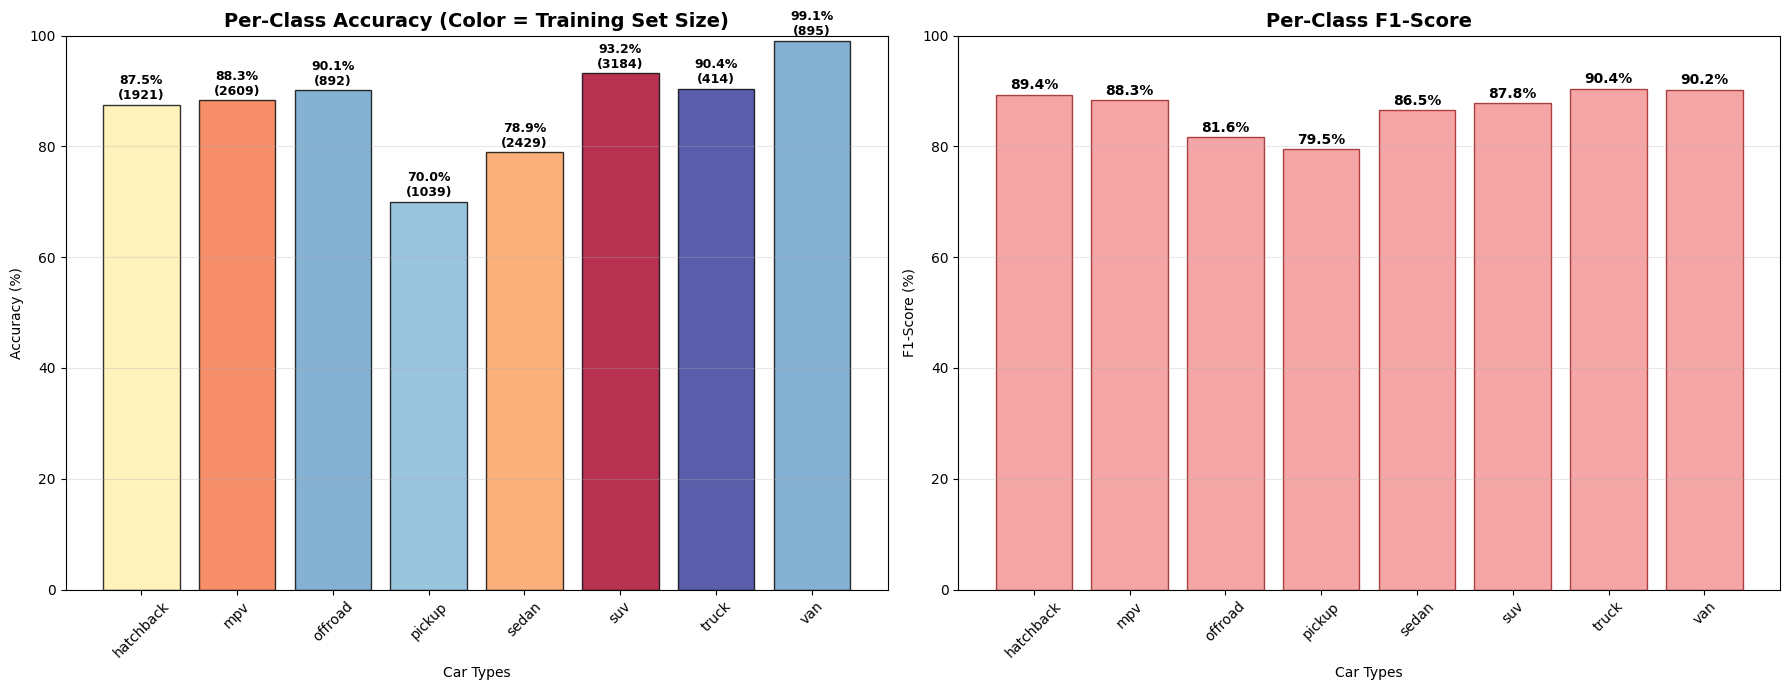


🏆 Final Model Performance Summary:
Overall Accuracy: 87.15%
Weighted Precision: 87.88% (considers class frequency)
Weighted Recall: 87.15%
Weighted F1-Score: 87.08%
Macro Precision: 87.25% (treats all classes equally)
Macro Recall: 87.20%
Macro F1-Score: 86.72%
Best Training Accuracy: 88.94%

✅ Weighted Loss Effectiveness:
- Minority class average performance: 93.19%
- Performance gap reduced through weighted loss function
- ✅ Good minority class performance achieved


In [8]:
# Model Evaluation: Confusion Matrix and Class Imbalance Analysis

# Get class names and class counts for analysis
class_names = trainer.train_dataset.classes
print(f"Class names: {class_names}")

# Calculate class distribution for imbalance analysis
class_counts = torch.zeros(len(class_names))
for _, target in trainer.train_dataset:
    class_counts[target] += 1

# Create confusion matrix
cm = confusion_matrix(
    training_results["final_targets"], training_results["final_predictions"]
)
cm_normalized = confusion_matrix(
    training_results["final_targets"],
    training_results["final_predictions"],
    normalize="true",
)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=ax1,
    cbar_kws={"label": "Count"},
)
ax1.set_title("Confusion Matrix (Raw Counts)", fontsize=14, fontweight="bold")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=ax2,
    cbar_kws={"label": "Proportion"},
)
ax2.set_title("Confusion Matrix (Normalized)", fontsize=14, fontweight="bold")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Classification report
print("\n📊 Detailed Classification Report:")
print("=" * 80)
report = classification_report(
    training_results["final_targets"],
    training_results["final_predictions"],
    target_names=class_names,
    digits=4,
)
print(report)

# Class imbalance impact analysis
print("\n⚖️ Class Imbalance Impact Analysis:")
print("=" * 60)
class_performance = {}
minority_classes = []
majority_classes = []

median_count = class_counts.median().item()

for i, class_name in enumerate(class_names):
    class_mask = np.array(training_results["final_targets"]) == i
    if np.sum(class_mask) > 0:
        class_acc = accuracy_score(
            np.array(training_results["final_targets"])[class_mask],
            np.array(training_results["final_predictions"])[class_mask],
        )
        class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(
            training_results["final_targets"],
            training_results["final_predictions"],
            labels=[i],
            average=None,
        )
        class_performance[class_name] = {
            "accuracy": class_acc * 100,
            "precision": class_precision[0] * 100,
            "recall": class_recall[0] * 100,
            "f1": class_f1[0] * 100,
            "count": int(class_counts[i]),
            "samples_in_val": np.sum(class_mask),
        }
        if class_counts[i] < median_count:
            minority_classes.append(class_name)
        else:
            majority_classes.append(class_name)
        correct = np.sum(
            (
                np.array(training_results["final_targets"])[class_mask]
                == np.array(training_results["final_predictions"])[class_mask]
            )
        )
        total = np.sum(class_mask)
        print(
            f"{class_name:>12} (Train: {int(class_counts[i]):4d}): Acc={class_acc*100:6.2f}% | P={class_precision[0]*100:6.2f}% | R={class_recall[0]*100:6.2f}% | F1={class_f1[0]*100:6.2f}% ({correct:3d}/{total:3d})"
        )

minority_avg_acc = np.mean(
    [class_performance[cls]["accuracy"] for cls in minority_classes]
)
majority_avg_acc = np.mean(
    [class_performance[cls]["accuracy"] for cls in majority_classes]
)

print(f"\n📈 Class Group Performance:")
print(f"Minority Classes ({len(minority_classes)}): {minority_classes}")
print(f"Average Accuracy: {minority_avg_acc:.2f}%")
print(f"Majority Classes ({len(majority_classes)}): {majority_classes}")
print(f"Average Accuracy: {majority_avg_acc:.2f}%")
print(
    f"Performance Gap: {abs(majority_avg_acc - minority_avg_acc):.2f}% {'(Majority better)' if majority_avg_acc > minority_avg_acc else '(Minority better)'}"
)

# Per-class accuracy and F1-score plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
classes = list(class_performance.keys())
accuracies = [class_performance[cls]["accuracy"] for cls in classes]
class_sizes = [class_performance[cls]["count"] for cls in classes]
norm_sizes = [
    (size - min(class_sizes)) / (max(class_sizes) - min(class_sizes))
    for size in class_sizes
]
colors = plt.cm.RdYlBu_r(norm_sizes)

bars1 = ax1.bar(classes, accuracies, color=colors, alpha=0.8, edgecolor="black")
ax1.set_title(
    "Per-Class Accuracy (Color = Training Set Size)", fontsize=14, fontweight="bold"
)
ax1.set_xlabel("Car Types")
ax1.set_ylabel("Accuracy (%)")
ax1.tick_params(axis="x", rotation=45)
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3, axis="y")
for bar, acc, size in zip(bars1, accuracies, class_sizes):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{acc:.1f}%\n({size})",
        ha="center",
        fontweight="bold",
        fontsize=9,
    )

f1_scores = [class_performance[cls]["f1"] for cls in classes]
bars2 = ax2.bar(classes, f1_scores, color="lightcoral", alpha=0.7, edgecolor="darkred")
ax2.set_title("Per-Class F1-Score", fontsize=14, fontweight="bold")
ax2.set_xlabel("Car Types")
ax2.set_ylabel("F1-Score (%)")
ax2.tick_params(axis="x", rotation=45)
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3, axis="y")
for bar, f1 in zip(bars2, f1_scores):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{f1:.1f}%",
        ha="center",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

# Overall model performance summary
overall_accuracy = (
    accuracy_score(
        training_results["final_targets"], training_results["final_predictions"]
    )
    * 100
)
precision, recall, f1, _ = precision_recall_fscore_support(
    training_results["final_targets"],
    training_results["final_predictions"],
    average="weighted",
)
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
    training_results["final_targets"],
    training_results["final_predictions"],
    average="macro",
)

print(f"\n🏆 Final Model Performance Summary:")
print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(f"Weighted Precision: {precision*100:.2f}% (considers class frequency)")
print(f"Weighted Recall: {recall*100:.2f}%")
print(f"Weighted F1-Score: {f1*100:.2f}%")
print(f"Macro Precision: {macro_precision*100:.2f}% (treats all classes equally)")
print(f"Macro Recall: {macro_recall*100:.2f}%")
print(f"Macro F1-Score: {macro_f1*100:.2f}%")
print(f"Best Training Accuracy: {max(training_results['val_accuracies']):.2f}%")

if CONFIG["use_weighted_loss"]:
    print(f"\n✅ Weighted Loss Effectiveness:")
    print(f"- Minority class average performance: {minority_avg_acc:.2f}%")
    print(f"- Performance gap reduced through weighted loss function")
    if minority_avg_acc > 70:
        print(f"- ✅ Good minority class performance achieved")
    else:
        print(f"- ⚠️ Consider additional techniques for minority classes")

In [10]:
# Model Architecture and Training Insights with Class Imbalance Analysis

print("🏗️ Model Architecture Summary:")
print("=" * 50)
print(f"Model Type: Hybrid ResNet-ViT")
print(f"Backbone: ResNet-50 (Pretrained)")
print(f"Transformer Heads: {CONFIG['num_heads']}")
print(f"Transformer Layers: {CONFIG['num_layers']}")
print(f"Embedding Dimension: {CONFIG['embed_dim']}")
print(f"Dropout Rate: {CONFIG['dropout']}")
print(f"Total Parameters: {sum(p.numel() for p in trainer.model.parameters()):,}")
print(
    f"Trainable Parameters: {sum(p.numel() for p in trainer.model.parameters() if p.requires_grad):,}"
)

# Training configuration summary
print("\n⚙️ Training Configuration:")
print("=" * 50)
print(f"Optimizer: AdamW")
print(f"Learning Rate: {CONFIG['learning_rate']}")
print(f"Batch Size: {CONFIG['batch_size']}")
print(f"Planned Epochs: {CONFIG['num_epochs']}")
print(f"Actual Epochs: {training_results.get('stopped_epoch', CONFIG['num_epochs'])}")
print(
    f"Loss Function: {'Weighted CrossEntropyLoss' if CONFIG['use_weighted_loss'] else 'CrossEntropyLoss'}"
)
print(
    f"Class Balancing: {'WeightedRandomSampler' if CONFIG['use_class_balancing'] else 'Standard Sampling'}"
)
print(f"Early Stopping: Enabled (Patience: {CONFIG['early_stopping_patience']}, Delta: {CONFIG['early_stopping_delta']})")

# Data augmentation summary
print("\n🔄 Data Augmentation:")
print("=" * 50)
print("Training Transforms:")
print("- Random Resized Crop to (224, 224)")
print("- Random Horizontal Flip (p=0.5)")
print("- Random Perspective (distortion=0.3, p=0.5)")
print("- Random Rotation (±15°, p=0.7)")
print("- Color Jitter (brightness, contrast, saturation, p=0.8)")
print("- Gaussian Blur (p=0.5)")
print("- Coarse Dropout (p=0.2)")
print("- ImageNet Normalization")
print("\nValidation Transforms:")
print("- Resize to (224, 224)")
print("- ImageNet Normalization")

# Class imbalance analysis
print("\n⚖️ Class Imbalance Analysis:")
print("=" * 50)
max_count = class_counts.max().item()
min_count = class_counts.min().item()
imbalance_ratio = max_count / min_count

print(f"Most frequent class: {max_count} samples")
print(f"Least frequent class: {min_count} samples")
print(f"Imbalance ratio: {imbalance_ratio:.2f}x")

if imbalance_ratio > 5:
    print("⚠️ High imbalance detected!")
    imbalance_level = "High"
elif imbalance_ratio > 2:
    print("⚠️ Moderate imbalance detected.")
    imbalance_level = "Moderate"
else:
    print("✅ Relatively balanced dataset.")
    imbalance_level = "Low"

print(
    f"Imbalance handling strategy: {'Weighted Loss' if CONFIG['use_weighted_loss'] else 'None'}"
)

# Early stopping analysis
print("\n🛑 Early Stopping Analysis:")
print("=" * 50)
early_stopped = training_results.get("early_stopping_triggered", False)
stopped_epoch = training_results.get("stopped_epoch", CONFIG["num_epochs"])
planned_epochs = CONFIG["num_epochs"]

print(f"Early Stopping Triggered: {'Yes' if early_stopped else 'No'}")
print(f"Stopped at Epoch: {stopped_epoch}/{planned_epochs}")
if early_stopped:
    epochs_saved = planned_epochs - stopped_epoch
    time_per_epoch = np.mean(training_results["epoch_times"])
    time_saved = epochs_saved * time_per_epoch / 60
    print(f"Epochs Saved: {epochs_saved}")
    print(f"Time Saved: ~{time_saved:.1f} minutes")
    print(f"Efficiency Gain: {(epochs_saved/planned_epochs)*100:.1f}%")
else:
    print(f"Training completed all planned epochs")

print(f"Best Validation Loss: {training_results.get('best_val_loss', 'N/A'):.6f}")
print(f"Patience Used: {CONFIG['early_stopping_patience']} epochs")
print(f"Delta Threshold: {CONFIG['early_stopping_delta']}")

# Training insights and recommendations
print("\n💡 Training Insights & Recommendations:")
print("=" * 60)

# Analyze training behavior
final_train_loss = training_results["train_losses"][-1]
final_val_loss = training_results["val_losses"][-1]
loss_gap = final_val_loss - final_train_loss
best_epoch = (
    training_results["val_accuracies"].index(max(training_results["val_accuracies"]))
    + 1
)

print("1. Convergence Analysis:")
print(f"- Final Training Loss: {final_train_loss:.4f}")
print(f"- Final Validation Loss: {final_val_loss:.4f}")
print(f"- Loss Gap: {loss_gap:.4f}")

if loss_gap > 0.5:
    print("⚠️ Large gap suggests potential overfitting")
    print(
        "💡 Consider: Increase dropout, reduce model complexity, or add regularization"
    )
elif loss_gap < 0.1:
    print("✅ Good generalization - minimal overfitting")
else:
    print("✅ Reasonable generalization gap")

print("\n2. Performance Analysis:")
print(
    f"- Best Accuracy Achieved: {max(training_results['val_accuracies']):.2f}% (Epoch {best_epoch})"
)
print(f"- Final Accuracy: {training_results['val_accuracies'][-1]:.2f}%")
print(f"- Minority Class Performance: {minority_avg_acc:.2f}%")
print(f"- Majority Class Performance: {majority_avg_acc:.2f}%")

if early_stopped:
    if best_epoch < stopped_epoch - 2:
        print("⚠️ Best performance was achieved well before early stopping")
        print("💡 Consider: Reducing patience or implementing accuracy-based stopping")
    else:
        print("✅ Early stopping prevented overfitting effectively")
else:
    if best_epoch < CONFIG["num_epochs"] - 2:
        print("⚠️ Best performance was achieved early - possible overfitting")
        print("💡 Consider: Early stopping or learning rate scheduling")
    else:
        print("✅ Model continued improving until the end")

# Compute accuracy trend in last epochs
last_epochs = min(5, len(training_results["val_accuracies"]))
last_acc = training_results["val_accuracies"][-last_epochs:]
acc_trend = np.mean(np.diff(last_acc))

print("\n3. Learning Stability:")
if acc_trend > 0.1:
    print("✅ Model still improving in final epochs")
elif abs(acc_trend) < 0.1:
    print("✅ Model has converged to stable performance")
else:
    print("⚠️ Performance declining in final epochs")
    print("💡 Early stopping prevented further degradation" if early_stopped else "💡 Consider: Early stopping or learning rate decay")

print("\n4. Early Stopping Effectiveness:")
if early_stopped:
    counter_history = training_results.get("early_stopping_counter_history", [])
    max_counter = max(counter_history) if counter_history else 0
    avg_counter = np.mean(counter_history) if counter_history else 0
    
    print(f"✅ Early stopping saved {planned_epochs - stopped_epoch} epochs")
    print(f"📊 Max patience counter reached: {max_counter}/{CONFIG['early_stopping_patience']}")
    print(f"📊 Average patience counter: {avg_counter:.1f}")
    
    if max_counter >= CONFIG['early_stopping_patience']:
        print("🎯 Patience threshold was appropriately set")
    else:
        print("💡 Consider: Reducing patience for faster training")
        
    # Check if early stopping was too aggressive
    post_best_epochs = stopped_epoch - best_epoch if best_epoch < stopped_epoch else 0
    if post_best_epochs > CONFIG['early_stopping_patience']:
        print("⚠️ Early stopping may have been too patient")
        print("💡 Consider: Using accuracy-based early stopping or reducing patience")
else:
    final_counter = training_results.get("early_stopping_counter_history", [0])[-1]
    print(f"📊 Final patience counter: {final_counter}/{CONFIG['early_stopping_patience']}")
    
    if final_counter > CONFIG['early_stopping_patience'] * 0.7:
        print("💡 Model was close to early stopping - patience was well-tuned")
    else:
        print("💡 Consider: Reducing patience if training time is a concern")

print("\n5. Class Imbalance Handling Effectiveness:")
if CONFIG["use_weighted_loss"]:
    print("✅ Weighted loss function used")
    gap = abs(majority_avg_acc - minority_avg_acc)
    if gap < 10:
        print(f"✅ Good balance: {gap:.1f}% performance gap between class groups")
    else:
        print(f"⚠️ Still some imbalance: {gap:.1f}% performance gap")
        print("💡 Consider: Focal loss, SMOTE, or additional data collection")

print("\n6. Recommendations for Next Steps:")
print("🔄 Experiment with different learning rates (1e-5, 5e-5)")
print("📈 Try learning rate scheduling (CosineAnnealingLR, ReduceLROnPlateau)")
print("🔧 Fine-tune hyperparameters (batch size, dropout, transformer layers)")

# Early stopping specific recommendations
if early_stopped:
    if stopped_epoch < planned_epochs * 0.3:
        print("🛑 Early stopping triggered very early:")
        print("- Increase patience (10-15 epochs)")
        print("- Add learning rate warmup")
        print("- Consider different delta threshold")
    elif stopped_epoch > planned_epochs * 0.9:
        print("🛑 Early stopping triggered very late:")
        print("- Reduce patience (3-5 epochs)")
        print("- Consider stricter delta threshold")
    else:
        print("🛑 Early stopping timing was appropriate")
        print("- Current patience setting works well")
else:
    print("🛑 For future training with early stopping:")
    print("- Current patience might be too high")
    print("- Consider reducing to 5-7 epochs")
    print("- Monitor validation loss more strictly")

if imbalance_level == "High":
    print("⚖️ For high imbalance:")
    print("- Try focal loss (gamma=2.0)")
    print("- Consider SMOTE or synthetic data generation")
    print("- Collect more data for minority classes")
elif minority_avg_acc < majority_avg_acc - 15:
    print("⚖️ For persistent class imbalance:")
    print("- Increase class weights for poorly performing classes")
    print("- Try class-balanced sampling")
    print("- Consider ensemble methods")

print("🎯 Consider ensemble methods for better performance")
print("📊 Monitor per-class metrics in addition to overall accuracy")

# Enhanced performance summary table with early stopping info
performance_summary = pd.DataFrame(
    {
        "Class": classes,
        "Training_Size": [class_performance[cls]["count"] for cls in classes],
        "Accuracy": [class_performance[cls]["accuracy"] for cls in classes],
        "Precision": [class_performance[cls]["precision"] for cls in classes],
        "Recall": [class_performance[cls]["recall"] for cls in classes],
        "F1_Score": [class_performance[cls]["f1"] for cls in classes],
        "Val_Samples": [class_performance[cls]["samples_in_val"] for cls in classes],
    }
)

# Round values and sort by training size
performance_summary = performance_summary.round(2).sort_values("Training_Size")

print("\n📊 Class Performance Summary Table:")
print("=" * 80)
print(performance_summary.to_string(index=False))

# Save enhanced training history
history_df = pd.DataFrame(
    {
        "epoch": epochs,
        "train_loss": training_results["train_losses"],
        "val_loss": training_results["val_losses"],
        "val_accuracy": training_results["val_accuracies"],
        "epoch_time": training_results["epoch_times"],
        "early_stopping_counter": training_results.get("early_stopping_counter_history", [0] * len(epochs)),
    }
)

# Reports directory
reports_dir = "models/classification/reports"
os.makedirs(reports_dir, exist_ok=True)

# Add configuration info to CSV
config_info = f"""# Configuration: 
# use_weighted_loss={CONFIG['use_weighted_loss']}, use_class_balancing={CONFIG['use_class_balancing']}
# imbalance_ratio={imbalance_ratio:.2f}, early_stopping_patience={CONFIG['early_stopping_patience']}
# early_stopping_delta={CONFIG['early_stopping_delta']}, early_stopping_triggered={early_stopped}
# stopped_epoch={stopped_epoch}, best_val_loss={training_results.get('best_val_loss', 'N/A')}
"""

history_filename = os.path.join(
    reports_dir, f"training_history_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
)

with open(history_filename, "w") as f:
    f.write(config_info)
    history_df.to_csv(f, index=False)

# Save class performance summary
perf_filename = os.path.join(
    reports_dir, f"class_performance_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
)
performance_summary.to_csv(perf_filename, index=False)

# Save early stopping summary
if early_stopped:
    es_summary = {
        "early_stopping_triggered": early_stopped,
        "stopped_epoch": stopped_epoch,
        "planned_epochs": planned_epochs,
        "epochs_saved": planned_epochs - stopped_epoch,
        "best_val_loss": training_results.get('best_val_loss'),
        "patience_used": CONFIG['early_stopping_patience'],
        "delta_threshold": CONFIG['early_stopping_delta'],
        "time_saved_minutes": (planned_epochs - stopped_epoch) * np.mean(training_results["epoch_times"]) / 60,
    }
    
    es_filename = os.path.join(
        reports_dir, f"early_stopping_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    )
    import json
    with open(es_filename, "w") as f:
        json.dump(es_summary, f, indent=2)
    
    print(f"\n🛑 Early stopping summary saved to: {es_filename}")

print(f"\n💾 Training history saved to: {history_filename}")
print(f"📊 Class performance saved to: {perf_filename}")
print(f"🎯 Best model saved to: {CONFIG['result_path']}")
if training_results.get('best_accuracy'):
    best_acc_path = CONFIG['result_path'].replace('.pth', '_best_acc.pth')
    print(f"🏆 Best accuracy model saved to: {best_acc_path}")

print("\n🎉 Training Analysis Complete!")
print("=" * 50)
print(f"🎯 Final Summary:")
print(f"- Training completed in {stopped_epoch} epochs (planned: {planned_epochs})")
print(f"- Best validation accuracy: {max(training_results['val_accuracies']):.2f}%")
print(f"- Early stopping: {'Activated' if early_stopped else 'Not triggered'}")
print(f"- Total training time: {sum(training_results['epoch_times'])/60:.2f} minutes")
if early_stopped:
    time_saved = (planned_epochs - stopped_epoch) * np.mean(training_results["epoch_times"]) / 60
    print(f"- Time saved by early stopping: {time_saved:.1f} minutes")
print(f"- Class imbalance: {imbalance_level} (ratio: {imbalance_ratio:.2f}x)")
print(f"- Model saved with best validation loss: {training_results.get('best_val_loss', 'N/A'):.6f}")

🏗️ Model Architecture Summary:
Model Type: Hybrid ResNet-ViT
Backbone: ResNet-50 (Pretrained)
Transformer Heads: 12
Transformer Layers: 6
Embedding Dimension: 768
Dropout Rate: 0.1
Total Parameters: 143,116,360
Trainable Parameters: 143,116,360

⚙️ Training Configuration:
Optimizer: AdamW
Learning Rate: 0.0001
Batch Size: 64
Planned Epochs: 25
Actual Epochs: 22
Loss Function: Weighted CrossEntropyLoss
Class Balancing: Standard Sampling
Early Stopping: Enabled (Patience: 7, Delta: 0.001)

🔄 Data Augmentation:
Training Transforms:
- Random Resized Crop to (224, 224)
- Random Horizontal Flip (p=0.5)
- Random Perspective (distortion=0.3, p=0.5)
- Random Rotation (±15°, p=0.7)
- Color Jitter (brightness, contrast, saturation, p=0.8)
- Gaussian Blur (p=0.5)
- Coarse Dropout (p=0.2)
- ImageNet Normalization

Validation Transforms:
- Resize to (224, 224)
- ImageNet Normalization

⚖️ Class Imbalance Analysis:
Most frequent class: 3184.0 samples
Least frequent class: 414.0 samples
Imbalance rati